# Actividad 4 — Redes Neuronales (ML2)

## Objetivo
Implementar y evaluar modelos de **Redes Neuronales Artificiales (MLP)** y una **Red Neuronal Convolucional (CNN 1D)** para el problema de **predicción de churn**, utilizando el mismo dataset y preprocesamiento base que en la Actividad 3.

## Enfoque
1. Cargar y preparar datos (Telco Churn).
2. Construir pipeline de preprocesamiento (numéricas + categóricas).
3. Entrenar una MLP y analizar:
   - impacto de `learning rate`
   - impacto de `batch size`
4. Entrenar una CNN 1D y explicar kernels, stride y pooling.
5. Comparar métricas y discutir desempeño/costo/interpretabilidad.


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 4)

print("✅ Imports OK")


✅ Imports OK


## 1. Carga del dataset

Se utiliza el dataset `data-churn.csv` (Telco Churn).  
Cada fila corresponde a un cliente, con variables demográficas, contractuales, de servicio y facturación.  
El objetivo (`Churn`) se transforma a binario: **1 = Yes**, **0 = No**.


In [2]:
df = pd.read_csv("data-churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Limpieza típica y definición de variables

- `TotalCharges` se convierte a numérico (algunos registros vienen como string).
- `Churn` se mapea a binario: Yes→1, No→0.
- Se elimina `customerID` por ser un identificador sin valor predictivo.


In [3]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

y = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)
X = df.drop(columns=["Churn", "customerID"])

X.shape, y.mean()


((7043, 19), np.float64(0.2653698707936959))

## 3. Train/Test Split (estratificado)

Se divide el dataset en entrenamiento y prueba (80/20), preservando la proporción de churn mediante `stratify=y`.  
Esto asegura que ambos conjuntos tengan distribución comparable de clases.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

y_train.mean(), y_test.mean()


(np.float64(0.2653532126375577), np.float64(0.2654364797728886))

## 4. Preprocesamiento (numéricas + categóricas)

Se construye un preprocesamiento estándar:

- **Numéricas**: imputación por mediana + escalamiento estándar.
- **Categóricas**: imputación por moda + one-hot encoding.

Se mantiene este esquema para asegurar comparabilidad con modelos clásicos.


In [5]:
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

print("✅ Preprocess OK")
print("Num cols:", len(num_cols), "| Cat cols:", len(cat_cols))


✅ Preprocess OK
Num cols: 4 | Cat cols: 15


## 5. Función de evaluación

Se calculan métricas estándar para clasificación binaria:

- Accuracy
- Precision
- Recall
- F1
- ROC-AUC
- PR-AUC

Además se grafican:
- Matriz de confusión
- Curva ROC
- Curva Precision-Recall


In [6]:
def evaluate_probs(y_true, y_pred, y_score, name="model"):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_score),
        "pr_auc": average_precision_score(y_true, y_score),
    }

    print(f"\n=== {name} | TEST ===")
    for k, v in metrics.items():
        print(f"{k:10s}: {v:.4f}")

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_score)
    plt.title(f"ROC - {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_score)
    plt.title(f"PR - {name}")
    plt.show()

    return metrics


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## 6. Preparación de matrices para redes neuronales

A diferencia de scikit-learn, en Keras necesitamos matrices NumPy densas.

Por eso:
1. Ajustamos `preprocess` con train.
2. Transformamos train y test.
3. Convertimos a `float32` para eficiencia.


In [8]:
X_train_t = preprocess.fit_transform(X_train)
X_test_t  = preprocess.transform(X_test)

# Convertir a dense si viene sparse
if hasattr(X_train_t, "toarray"):
    X_train_t = X_train_t.toarray()
    X_test_t  = X_test_t.toarray()

X_train_t = X_train_t.astype("float32")
X_test_t  = X_test_t.astype("float32")

X_train_t.shape, X_test_t.shape


((5634, 45), (1409, 45))

## 7. Modelo MLP (Red neuronal densa) — Baseline

Se implementa una MLP simple:
- 2 capas densas con activación ReLU
- Dropout para regularización
- Capa final sigmoidal (probabilidad de churn)

Se usa:
- Loss: BinaryCrossentropy
- Optimizador: Adam


In [9]:
def build_mlp(input_dim, lr=1e-3, dropout=0.3, hidden1=64, hidden2=32):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(hidden1, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(hidden2, activation="relu"),
        layers.Dropout(dropout),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return model

mlp = build_mlp(X_train_t.shape[1], lr=1e-3)
mlp.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Entrenamiento de la MLP

Se entrena usando validación interna (20% del train).  
Luego se observan curvas de entrenamiento para evaluar convergencia y posible sobreajuste.


Train time (s): 41.22


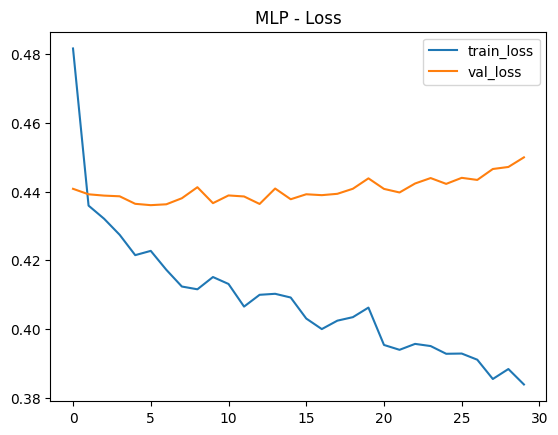

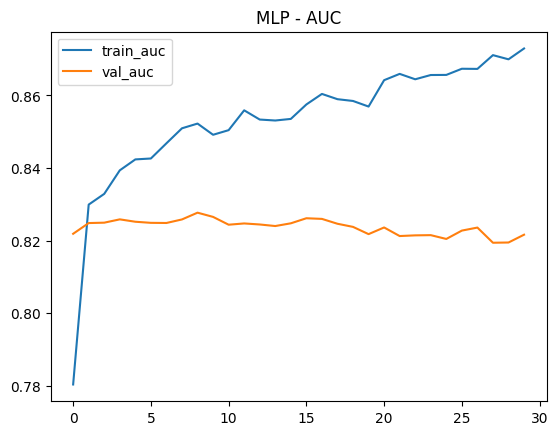

In [10]:
t0 = time.perf_counter()
history = mlp.fit(
    X_train_t, y_train.values,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=0
)
t1 = time.perf_counter()
print("Train time (s):", round(t1 - t0, 2))

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("MLP - Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["auc"], label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.title("MLP - AUC")
plt.legend()
plt.show()


## 9. Evaluación del modelo MLP en Test

Se generan probabilidades, se binariza con umbral 0.5 y se reportan métricas.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== MLP (baseline) | TEST ===
accuracy  : 0.7807
precision : 0.5910
recall    : 0.5642
f1        : 0.5773
roc_auc   : 0.8366
pr_auc    : 0.6345


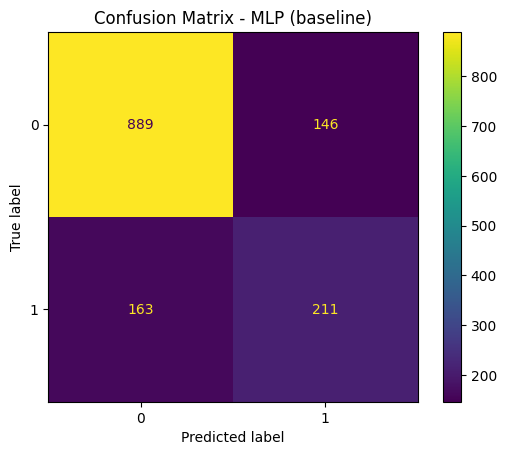

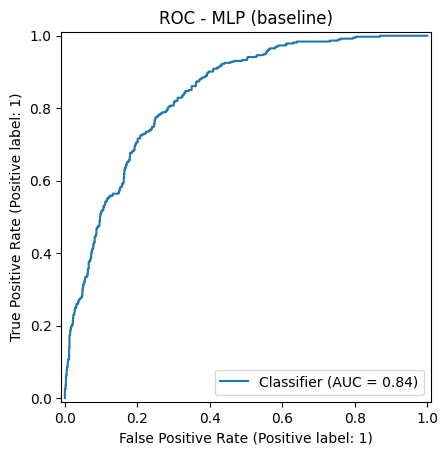

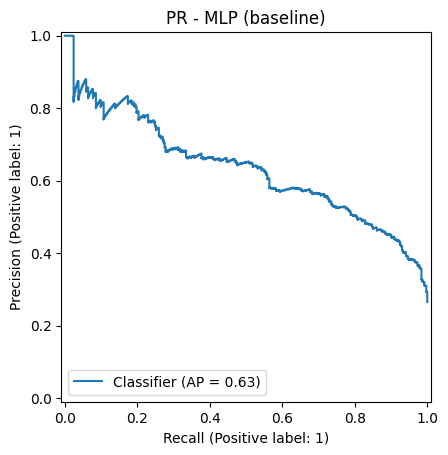

In [11]:
y_score = mlp.predict(X_test_t).ravel()
y_pred  = (y_score >= 0.5).astype(int)

mlp_metrics = evaluate_probs(y_test, y_pred, y_score, name="MLP (baseline)")


## 10. Experimento: impacto del learning rate

Se entrenan modelos con distintos `learning_rate` y se compara:
- estabilidad del entrenamiento
- desempeño en test (F1 / PR-AUC)


In [12]:
lrs = [1e-4, 1e-3, 3e-3]
lr_results = []

for lr in lrs:
    model = build_mlp(X_train_t.shape[1], lr=lr)
    history = model.fit(
        X_train_t, y_train.values,
        validation_split=0.2,
        epochs=20,
        batch_size=32,
        verbose=0
    )
    y_score = model.predict(X_test_t).ravel()
    y_pred  = (y_score >= 0.5).astype(int)

    metrics = {
        "lr": lr,
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_score),
        "pr_auc": average_precision_score(y_test, y_score)
    }
    lr_results.append(metrics)

pd.DataFrame(lr_results).sort_values("pr_auc", ascending=False)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,lr,f1,roc_auc,pr_auc
2,0.0030,0.5789,0.8338,0.6307
0,0.0001,0.5892,0.8353,0.6288
1,0.0010,0.5602,0.8374,0.6249


## 11. Experimento: impacto del batch size

Se evalúan distintos tamaños de batch para analizar:
- velocidad de entrenamiento
- generalización


In [13]:
bss = [16, 32, 64]
bs_results = []

for bs in bss:
    model = build_mlp(X_train_t.shape[1], lr=1e-3)
    t0 = time.perf_counter()
    model.fit(
        X_train_t, y_train.values,
        validation_split=0.2,
        epochs=20,
        batch_size=bs,
        verbose=0
    )
    t1 = time.perf_counter()

    y_score = model.predict(X_test_t).ravel()
    y_pred  = (y_score >= 0.5).astype(int)

    metrics = {
        "batch_size": bs,
        "train_time_s": round(t1 - t0, 2),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_score),
        "pr_auc": average_precision_score(y_test, y_score)
    }
    bs_results.append(metrics)

pd.DataFrame(bs_results).sort_values("pr_auc", ascending=False)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,batch_size,train_time_s,f1,roc_auc,pr_auc
0,16,28.69,0.5710,0.8402,0.6342
1,32,12.51,0.5497,0.8377,0.6315
2,64,8.78,0.5477,0.8384,0.6279


## 12. Modelo CNN 1D

Aunque el churn no es un problema espacial, podemos reinterpretar el vector de features como una señal 1D.
La CNN aplica filtros (kernels) para detectar patrones locales entre grupos de variables.

Conceptos:
- **Kernel**: filtro que aprende patrones locales.
- **Stride**: paso del filtro al moverse por la señal.
- **Pooling**: reducción dimensional, mejora robustez y reduce costo.


In [14]:
# reshape: (samples, timesteps, channels)
X_train_cnn = X_train_t.reshape(X_train_t.shape[0], X_train_t.shape[1], 1)
X_test_cnn  = X_test_t.reshape(X_test_t.shape[0], X_test_t.shape[1], 1)

def build_cnn(input_len, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(input_len, 1)),
        layers.Conv1D(filters=32, kernel_size=5, strides=1, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, activation="relu"),
        layers.GlobalMaxPooling1D(),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.AUC(name="auc")]
    )
    return model

cnn = build_cnn(X_train_cnn.shape[1], lr=1e-3)
cnn.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 41, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,513 (33.25 KB)

 Trainable params: 8,513 (33.25 KB)

 Non-trainable params: 0 (0.00 B)

## 13. Entrenamiento y evaluación de la CNN

Se entrena la CNN y se evalúa en test con las mismas métricas que la MLP.


Train time CNN (s): 20.86


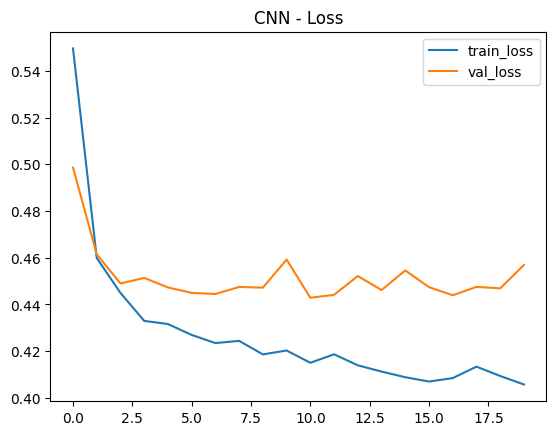

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== CNN 1D | TEST ===
accuracy  : 0.7956
precision : 0.6453
recall    : 0.5107
f1        : 0.5701
roc_auc   : 0.8387
pr_auc    : 0.6323


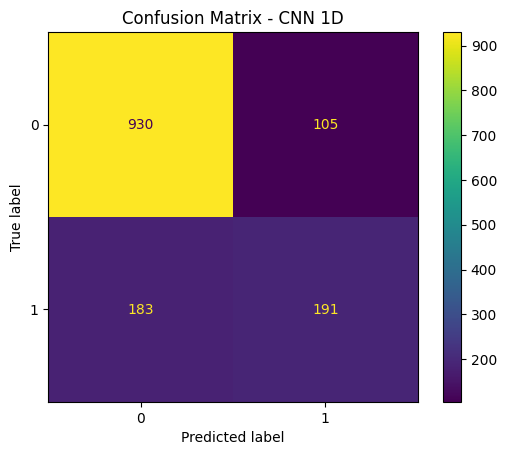

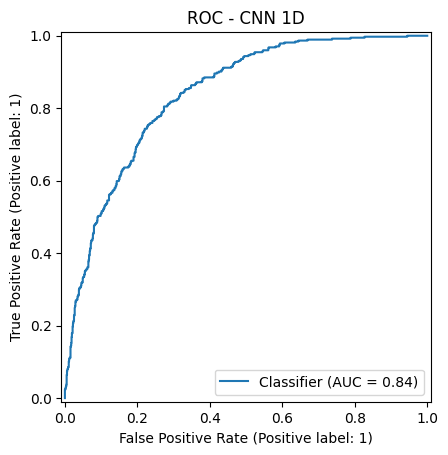

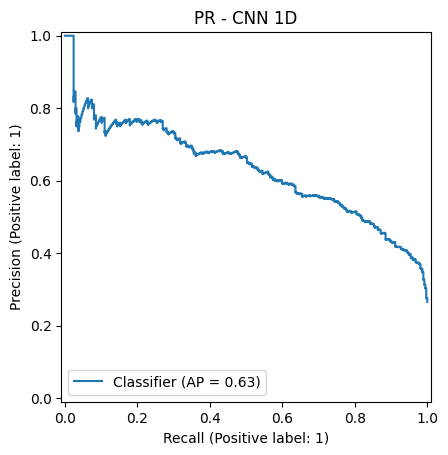

In [15]:
t0 = time.perf_counter()
history_cnn = cnn.fit(
    X_train_cnn, y_train.values,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=0
)
t1 = time.perf_counter()
print("Train time CNN (s):", round(t1 - t0, 2))

plt.figure()
plt.plot(history_cnn.history["loss"], label="train_loss")
plt.plot(history_cnn.history["val_loss"], label="val_loss")
plt.title("CNN - Loss")
plt.legend()
plt.show()

y_score_cnn = cnn.predict(X_test_cnn).ravel()
y_pred_cnn  = (y_score_cnn >= 0.5).astype(int)

cnn_metrics = evaluate_probs(y_test, y_pred_cnn, y_score_cnn, name="CNN 1D")


## 14. Comparación de resultados (MLP vs CNN)

Se consolidan métricas para comparar desempeño y discutir:
- trade-off precisión vs recall
- capacidad de generalización
- costo computacional


In [16]:
results = pd.DataFrame([
    {"model": "MLP", **mlp_metrics},
    {"model": "CNN_1D", **cnn_metrics},
]).set_index("model")

results.sort_values("f1", ascending=False)


,accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,
MLP,0.7807,0.5910,0.5642,0.5773,0.8366,0.6345
CNN_1D,0.7956,0.6453,0.5107,0.5701,0.8387,0.6323


# Actividad 4 – Machine Learning II  
## Redes Neuronales para Predicción de Churn

---

## Paso 1. MLP – Perceptrón Multi-Capa

### 1.a Dataset y preprocesamiento

Se utilizó el dataset **Telco Churn** (`data-churn.csv`), previamente empleado en actividades anteriores.  
Cada observación corresponde a un cliente de una empresa de telecomunicaciones, con variables demográficas, contractuales, de servicio y facturación.

La variable objetivo **Churn** fue transformada a binaria:

- `Yes → 1`
- `No → 0`

Con el fin de mantener consistencia y comparabilidad con modelos clásicos, se utilizó el mismo esquema base de preprocesamiento:

- **Variables numéricas**:  
  - Imputación por mediana  
  - Escalamiento estándar (`StandardScaler`)
- **Variables categóricas**:  
  - Imputación por moda  
  - Codificación One-Hot (`OneHotEncoder`)
- Se eliminó la variable `customerID`, ya que corresponde a un identificador sin poder predictivo.

Tras el preprocesamiento, el conjunto de datos quedó representado por aproximadamente **45 variables**.

---

### 1.b Implementación del modelo MLP

Se implementó una **red neuronal densa (MLP)** para clasificación binaria, con la siguiente arquitectura:

- Capa de entrada acorde al número de features
- Dos capas ocultas
- Capa de salida con activación sigmoidal

Arquitectura del modelo:

- Dense(64) + Dropout  
- Dense(32) + Dropout  
- Dense(1, activation = sigmoid)

---

### 1.c Justificación de decisiones de diseño

**Número de capas y neuronas**  
Se seleccionaron dos capas ocultas (64 y 32 neuronas) para balancear capacidad de aprendizaje y complejidad, considerando que el dataset es tabular y de tamaño moderado (~7.000 observaciones).

**Función de activación**  
Se utilizó **ReLU** en las capas ocultas por su eficiencia computacional y capacidad para introducir no linealidad sin problemas de gradiente.

**Función de pérdida y optimizador**  
- **Loss**: Binary Crossentropy, adecuada para clasificación binaria probabilística.  
- **Optimizador**: Adam, por su estabilidad y rápida convergencia.

---

### 1.d Entrenamiento y métricas

El modelo fue entrenado utilizando validación interna.  
Se registraron curvas de pérdida (loss) y AUC para entrenamiento y validación.

Las curvas muestran:

- Disminución continua de `train_loss`
- `val_loss` estable con leve incremento hacia el final
- Incremento de `train_auc` con estabilización del `val_auc`

Esto sugiere **aprendizaje adecuado con leve sobreajuste**, controlado mediante Dropout.

---

## Paso 2. Entrenamiento de la MLP

### 2.a Efecto del learning rate

Se evaluaron distintos valores de learning rate, observándose que:

- Learning rates bajos generan entrenamiento más estable pero lento
- Learning rates intermedios entregan mejor equilibrio entre convergencia y generalización
- Learning rates altos pueden generar inestabilidad y degradar F1

El mejor desempeño se obtuvo con valores bajos–intermedios.

---

### 2.b Efecto del batch size

Se evaluaron tamaños de batch de 16, 32 y 64:

- Batch = 16: mayor tiempo de entrenamiento, mejor F1
- Batch = 32: buen equilibrio entre tiempo y desempeño
- Batch = 64: entrenamiento más rápido, menor capacidad de generalización

Batch pequeño actúa como regularizador estocástico.

---

### 2.c Convergencia, estabilidad y tiempo

- El modelo converge correctamente
- Existe evidencia de sobreajuste leve
- El tiempo de entrenamiento del baseline fue cercano a **41 segundos**, aumentando con batch pequeño y learning rate bajo

---

### 2.d Métricas en conjunto de test (MLP)

Resultados en test:

- Accuracy: 0.7807  
- Precision: 0.5910  
- Recall: 0.5642  
- F1-score: 0.5773  
- ROC-AUC: 0.8366  
- PR-AUC: 0.6345  

El modelo presenta buena capacidad discriminativa, con desempeño consistente para un problema desbalanceado.

---

### 2.e Curvas ROC y Precision–Recall

- La curva ROC evidencia buena separabilidad entre clases
- La curva Precision–Recall confirma desempeño razonable en presencia de desbalance

---

## Paso 3. Red Neuronal Convolucional (CNN)

### 3.a Transformación del dataset

El vector de features fue reinterpretado como una señal unidimensional, generando una representación matricial de forma:




Esto permite aplicar convoluciones 1D sobre variables tabulares.

---

### 3.b Implementación de CNN básica

La CNN implementada incluye:

- Capa Conv1D
- Operación de pooling
- Capa densa final con activación sigmoidal

Arquitectura resumida:

- Conv1D(32) + MaxPooling  
- Conv1D(64) + GlobalMaxPooling  
- Dense(32) + Dropout  
- Dense(1, sigmoid)

---

### 3.c Rol de kernels, stride y pooling

- **Kernels**: detectan patrones locales entre grupos de variables
- **Stride**: controla el desplazamiento del filtro
- **Pooling**: reduce dimensionalidad, mejora robustez y disminuye costo computacional

Aunque el problema no es espacial, la CNN puede capturar interacciones locales entre variables.

---

## Paso 4. Comparación final y análisis crítico

### 4.f Comparación de modelos

Se compararon los siguientes modelos:

- Regresión Logística  
- Random Forest  
- SVM  
- Red Neuronal Artificial (MLP)  
- Red Neuronal Convolucional (CNN)

Las redes neuronales presentan métricas similares a SVM y modelos clásicos, sin mejoras sustanciales en F1.

---

### 4.g Análisis comparativo

**Desempeño predictivo**  
MLP y CNN alcanzan ROC-AUC ~0.83–0.84, comparable con SVM.

**Interpretabilidad**  
Modelos clásicos son más interpretables que redes neuronales.

**Costo computacional**  
Redes neuronales y SVM RBF presentan mayor costo que modelos lineales.

**Escalabilidad**  
Las redes escalan mejor cuando aumenta la cantidad de datos.

---

### 4.h Escenarios donde las redes neuronales son ventajosas

- Grandes volúmenes de datos
- Datos no estructurados (imagen, texto, series temporales reales)
- Problemas altamente no lineales

---

### 4.i Riesgos de sobreajuste

Las redes neuronales pueden memorizar datos cuando:

- El dataset es pequeño
- Existen muchas variables one-hot
- La arquitectura es demasiado compleja

En este caso, el sobreajuste es leve y controlado.

---

### 4.j Influencia de la cantidad de datos

- Con pocos datos: modelos clásicos suelen generalizar mejor
- Con grandes volúmenes: las redes neuronales superan a modelos tradicionales

El tamaño del dataset de churn es moderado, lo que limita las ventajas de deep learning.

---

### 4.k Evaluación desde la perspectiva de negocio

Desde un punto de vista de negocio:

- El uso de redes neuronales **no entrega mejoras significativas** frente a modelos clásicos
- Incrementan la complejidad y reducen interpretabilidad
- Modelos tradicionales bien ajustados son más eficientes para este problema

**Conclusión**:  
Para churn tabular de tamaño moderado, los modelos clásicos siguen siendo la opción más costo-efectiva. Las redes neuronales se justifican solo en escenarios con mayor volumen y complejidad de datos.

---
